# Import Data

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import scikitplot as skplt

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [78]:
df_combined = pd.read_csv("data/exported/df_combined.csv", index_col = 0)
df_not_combined = pd.read_csv("data/exported/df_not_combined.csv", index_col = 0)

In [79]:
df_not_combined

,ref_pos,ref_kmer,dwell_time,median_value,ref_number,file_name,read_num,modified_status,base_1,base_2,base_3,base_4,base_5,file_type,dwell_time_rolling_median,median_value_rolling_median,dwell_time_rolling_min,median_value_rolling_min
0,0,AATGG,0.074466,108.450395,ref_0000,modified_rep_1.tsv,#0_0,1.0,A,A,T,G,G,modified,0.033993,108.450395,0.021499,108.417694
1,1,ATGGG,0.021499,110.385196,ref_0000,modified_rep_1.tsv,#0_0,0.0,A,T,G,G,G,modified,0.027746,109.417796,0.005762,108.417694
2,2,TGGGC,0.033993,108.417694,ref_0000,modified_rep_1.tsv,#0_0,0.0,T,G,G,G,C,modified,0.026592,110.385196,0.005762,108.417694
3,3,GGGCT,0.005762,110.508778,ref_0000,modified_rep_1.tsv,#0_0,0.0,G,G,G,C,T,modified,0.021499,110.385196,0.005762,79.882353
4,4,GGCTT,0.026592,112.052889,ref_0000,modified_rep_1.tsv,#0_0,0.0,G,G,C,T,T,modified,0.008281,108.417694,0.005762,79.882353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225395,191,CGTGC,0.006416,91.601589,ref_0004,unmodified_rep_2.tsv,#4_59,0.0,C,G,T,G,C,unmodified,0.006416,91.601589,0.002183,79.453407
225396,192,GTGCC,0.030970,82.289917,ref_0004,unmodified_rep_2.tsv,#4_59,0.0,G,T,G,C,C,unmodified,0.006948,82.289917,0.002183,72.236485
225397,193,TGCCT,0.002183,102.220231,ref_0004,unmodified_rep_2.tsv,#4_59,0.0,T,G,C,C,T,unmodified,0.006416,91.601589,0.002183,72.236485
225398,194,GCCTG,0.019195,72.236485,ref_0004,unmodified_rep_2.tsv,#4_59,0.0,G,C,C,T,G,unmodified,0.012435,88.040754,0.002183,72.236485


In [80]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object"})

In [81]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_combined = df_combined.astype({"ref_number":"object"})

# modeling

In [82]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report, adjusted_rand_score, adjusted_mutual_info_score 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,StackingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from pprint import pprint
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

## train test split

In [83]:
# manual train test split according to ref_num to preserve sequence sequence identity
# maybe do it according to read_num to increase variability?

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
train_ref = ["ref_0000","ref_0001","ref_0002"]
test_ref = ["ref_0003"]

In [84]:
seed = 7

### not_combined

In [85]:
X_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
y_finaltest_not_combined = X_finaltest_not_combined.pop("modified_status")
X_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
y_val_not_combined = X_val_not_combined.pop("modified_status")
X_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
y_train_not_combined = X_train_not_combined.pop("modified_status")
X_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]
y_test_not_combined = X_test_not_combined.pop("modified_status")

In [86]:
numeric_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "float"])

In [87]:
numeric_features_not_combined

['dwell_time',
 'median_value',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min']

In [88]:
cat_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "category"])

In [89]:
cat_features_not_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [90]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_not_combined = SimpleImputer(strategy="median")
scaler1_not_combined = StandardScaler()
numeric_transformer_not_combined = make_pipeline(imputer1_not_combined,scaler1_not_combined)


imputer2_not_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_not_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_not_combined = make_pipeline(imputer2_not_combined,encoder_not_combined)

preprocessor_not_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined),
        ('cat', cat_transformer_not_combined, cat_features_not_combined)
    ])

### combined

In [91]:
X_finaltest_combined = df_combined[df_combined["ref_number"].isin(final_ref)]
y_finaltest_combined = X_finaltest_combined.pop("modified_status")
X_val_combined = df_combined[df_combined["ref_number"].isin(val_ref)]
y_val_combined = X_val_combined.pop("modified_status")
X_train_combined = df_combined[df_combined["ref_number"].isin(train_ref)]
y_train_combined = X_train_combined.pop("modified_status")
X_test_combined = df_combined[df_combined["ref_number"].isin(test_ref)]
y_test_combined = X_test_combined.pop("modified_status")

In [92]:
numeric_features_combined = list(X_train_combined .columns[X_train_combined .dtypes ==  "float"])

In [93]:
numeric_features_combined

['dwell_time_median',
 'dwell_time_std',
 'dwell_time_min',
 'dwell_time_max',
 'median_value_median',
 'median_value_std',
 'median_value_min',
 'median_value_max',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min']

In [94]:
cat_features_combined = list(X_train_combined.columns[X_train_combined.dtypes ==  "category"])

In [95]:
cat_features_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [96]:
imputer1_combined = SimpleImputer(strategy="median")
scaler1_combined = StandardScaler()
numeric_transformer_combined = make_pipeline(imputer1_combined,scaler1_combined)


imputer2_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_combined = make_pipeline(imputer2_combined,encoder_combined)

preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined),
        ('cat', cat_transformer_combined, cat_features_combined)
    ])

## supervised

In [97]:
# model selector class to choose models

class ModelSelector():
    
    def __init__(self, preprocessor, sampler=None):
        # initialise class with predetrmined models and tests, maybe add functions to add/change them afterwards?
        # add option to use a sampler (default = none)
        self.results = []
        self.name = []
        self.preprocessor = preprocessor
        self.sampler = sampler
        self.cv = []
        self.labels = []
        self.cv_state = True
        self.scoring = {'precision':'precision',
                        'recall': 'recall',
                        'f1score':'f1',
                        'roc auc':'roc_auc'}
        self.models = [
                        ('LR', LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1)),
                        ('KNN', KNeighborsClassifier(n_jobs = -1)),
                        ('RF', RandomForestClassifier(random_state=seed, n_jobs = -1)),
                        ('ADAB', AdaBoostClassifier(random_state=seed)),
                        ('XGB',  XGBClassifier(random_state=seed, n_jobs = -1)),
                        ('SVC', SVC(random_state=seed)),
                        ('GNB', GaussianNB())
                    ]


    # function for determining the cvs, if True do cv for each ref_num
    def __cv__(self, X):
        if self.cv_state == True:
            self.labels = X.ref_number.values
            self.cv = [(np.where(self.labels != label)[0], np.where(self.labels == label)[0]) for label in np.unique(self.labels)]
        else:
            self.cv = 5
   

    # fit each model and do cv and record cvs and names
    def __model_selection__(self, X, y, state):
        self.cv_state = state
        self.__cv__(X)
        results = []
        names = []
        val = []
        for name, model in self.models:
            model_pipe = Pipeline([(self.preprocessor.__class__.__name__,self.preprocessor),
                                   (self.sampler.__class__.__name__,self.sampler),("name",model)])
            cv_results = cross_validate(model_pipe, X, y, cv=self.cv, scoring=self.scoring, n_jobs=-1, return_train_score=True)
            self.results.append(cv_results)
            self.name.append(name)
    
    def select_model(self,X,y,state):
        # plot the test scores for each test and each model
        self.__model_selection__(X,y,state)
        tests = ["test_"+elm for elm in self.scoring.keys()]
        plt.figure(figsize = (15,8))
        plt.suptitle('Algorithm Comparison')
        for idx, test in enumerate(tests):
            temp_results = [self.results[i][test] for i in range(len(self.results))]
            plt.subplot(1,len(tests),idx+1)
            sns.boxplot(y = temp_results, x = self.name)
            plt.title(test)
            plt.xticks(rotation = 90)
            plt.ylim(0,1.05)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)


### baseline

In [98]:
y_pred = np.zeros(len(X_val_not_combined))

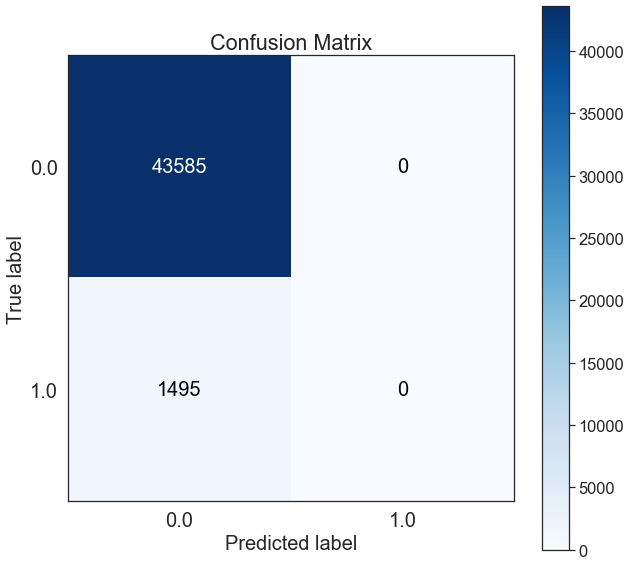

In [99]:
skplt.metrics.plot_confusion_matrix(y_val_not_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [100]:
print(classification_report(y_val_not_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     43585
         1.0       0.00      0.00      0.00      1495

    accuracy                           0.97     45080
   macro avg       0.48      0.50      0.49     45080
weighted avg       0.93      0.97      0.95     45080



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### classical ml models

#### model selection

In [101]:
sel = ModelSelector(preprocessor_not_combined)

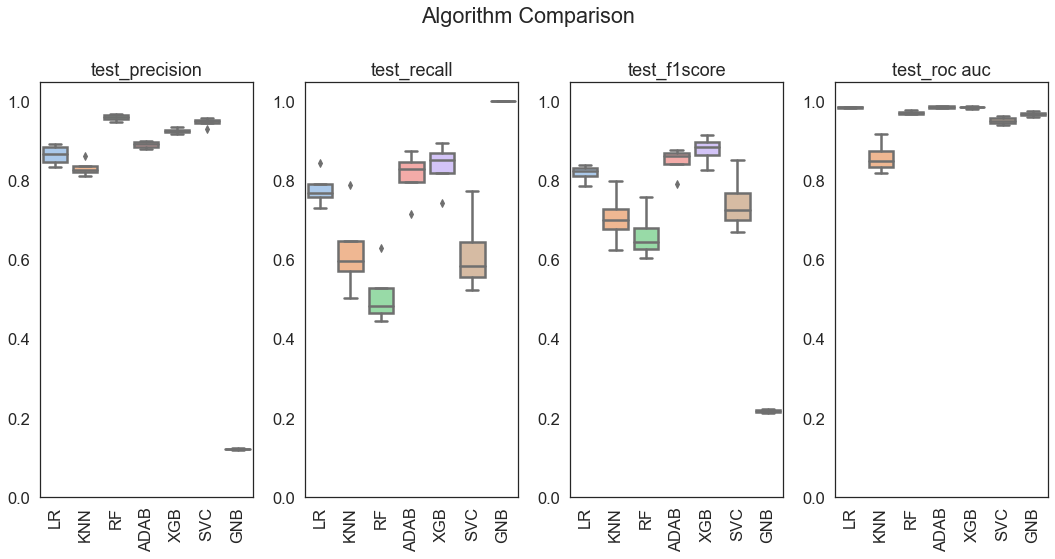

In [102]:
sel.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

#### xgb gridsearch

In [121]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[500],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [122]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined,xgb_clf)

In [123]:
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [124]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 500}


In [125]:
y_pred=grid_xgb.predict(X_val_not_combined)

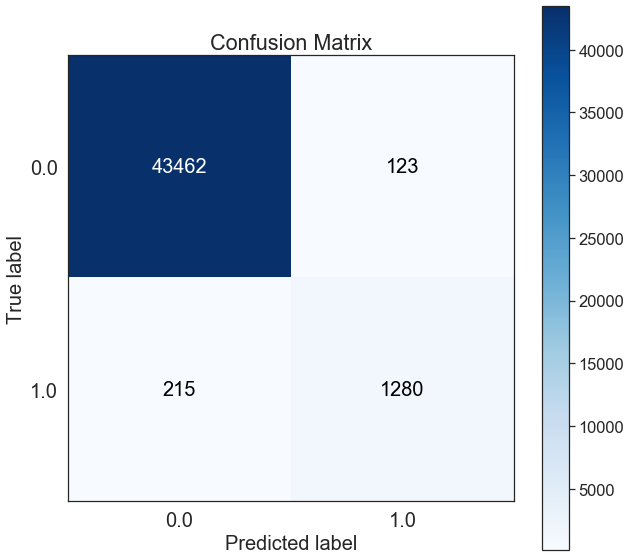

In [126]:
skplt.metrics.plot_confusion_matrix(y_val_not_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [127]:
print(classification_report(y_val_not_combined,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.86      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080



In [128]:
y_pred_ref_pos = X_val_not_combined.ref_pos.values
ratio_df = pd.DataFrame(pd.concat([pd.Series(y_pred),pd.Series(y_pred_ref_pos)],axis=1))
ratio_df.columns =["predicted","ref_pos"]

In [129]:
for elm in ratio_df.ref_pos.unique():
    msk = ratio_df[ratio_df.ref_pos == elm]
    print("Ratio of modified Reads for ref_pos " + str(elm) + " is :" + 
          str(round((len(msk[msk.predicted == 1])/len(msk))*100,2)))

Ratio of modified Reads for ref_pos 0 is :2.17
Ratio of modified Reads for ref_pos 1 is :0.0
Ratio of modified Reads for ref_pos 2 is :0.0
Ratio of modified Reads for ref_pos 3 is :0.0
Ratio of modified Reads for ref_pos 4 is :0.0
Ratio of modified Reads for ref_pos 5 is :0.0
Ratio of modified Reads for ref_pos 6 is :0.0
Ratio of modified Reads for ref_pos 7 is :0.0
Ratio of modified Reads for ref_pos 8 is :0.0
Ratio of modified Reads for ref_pos 9 is :0.43
Ratio of modified Reads for ref_pos 10 is :0.0
Ratio of modified Reads for ref_pos 11 is :0.0
Ratio of modified Reads for ref_pos 12 is :0.0
Ratio of modified Reads for ref_pos 13 is :0.0
Ratio of modified Reads for ref_pos 14 is :0.0
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 16 is :0.0
Ratio of modified Reads for ref_pos 17 is :0.0
Ratio of modified Reads for ref_pos 18 is :0.0
Ratio of modified Reads for ref_pos 19 is :0.0
Ratio of modified Reads for ref_pos 20 is :0.0
Ratio of modified R

#### feature importances

In [132]:
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [133]:
X_trans = preprocessor_not_combined.fit_transform(X_finaltest_not_combined)

In [134]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 500)

In [135]:
xgb.fit(X_trans, y_finaltest_not_combined)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [136]:
bases = ["_A","_C","_T","_G"]
cat = [elm + base for elm in cat_features_not_combined for base in bases ]

In [137]:
feature_names = numeric_features_not_combined + cat

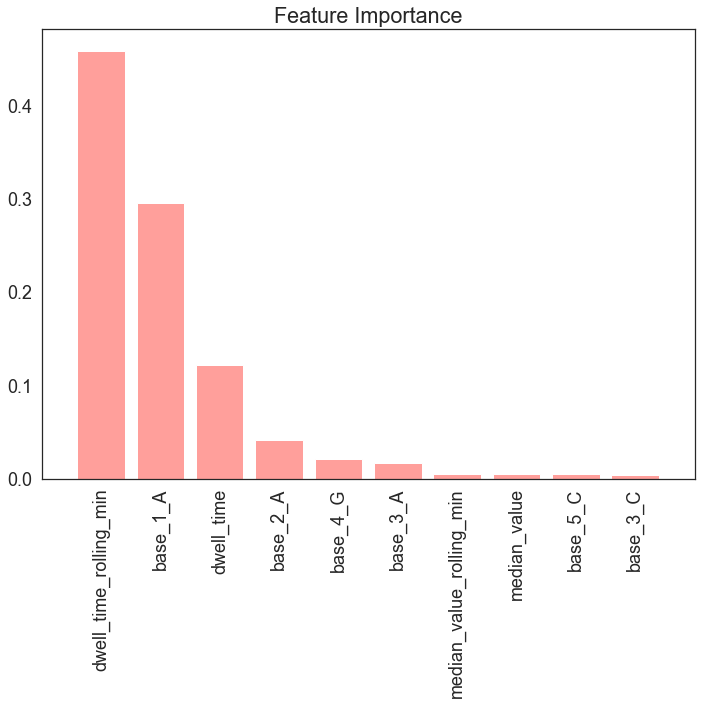

In [138]:
skplt.estimators.plot_feature_importances(xgb, feature_names=feature_names, max_num_features=10)
plt.xticks(rotation=90);

### Classical ml models with Oversampling

In [139]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


#### model selection

In [ ]:
sel_os = ModelSelector(preprocessor_not_combined, smotet)

sel_os.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

#### xgb gridsearch

In [ ]:
param_grid_xgb = {'xgbclassifier__max_depth':[5,7,10],
                 'xgbclassifier__learning_rate':[0.05,0.1,0.2],
                 'xgbclassifier__n_estimators':[10,20,50,100],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0,0.005,0.01,0.02]}

In [ ]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_not_combined),("smt",smotet),("xgbclassifier",xgb_clf)])

In [ ]:
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [ ]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

In [ ]:
y_pred=grid_xgb.predict(X_val_not_combined)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val_not_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [ ]:
print(classification_report(y_val_not_combined,y_pred))

## supervised combined

### baseline

In [ ]:
y_pred = np.zeros(len(X_val_combined))

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [ ]:
print(classification_report(y_val_combined,y_pred))

### classical ml models

#### model selection

In [ ]:
sel = ModelSelector(preprocessor_combined)

In [ ]:
sel.select_model(X_finaltest_combined, y_finaltest_combined, True)

#### xgb gridsearch

In [ ]:
param_grid_xgb = {'xgbclassifier__max_depth':[1,2,5],
                 'xgbclassifier__learning_rate':[0.1,0.2,0.3],
                 'xgbclassifier__n_estimators':[200,300,400],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0,0.01]}

In [ ]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_combined,xgb_clf)

In [ ]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [ ]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

In [ ]:
y_pred=grid_xgb.predict(X_val_combined)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val_combined, y_pred, figsize=(10,10), text_fontsize=20)


In [ ]:
print(classification_report(y_val_combined,y_pred))

In [ ]:
y_pred_ref_pos = X_val_combined.ref_pos.values
ratio_df = pd.DataFrame(pd.concat([pd.Series(y_pred),pd.Series(y_pred_ref_pos)],axis=1))
ratio_df.columns =["predicted","ref_pos"]

In [ ]:
for elm in ratio_df.ref_pos.unique():
    msk = ratio_df[ratio_df.ref_pos == elm]
    print("Ratio of modified Reads for ref_pos " + str(elm) + " is :" + 
          str(round((len(msk[msk.predicted == 1])/len(msk))*100,2)))

#### feature importances

In [ ]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [ ]:
X_trans = preprocessor_combined.fit_transform(X_finaltest_combined)

In [ ]:

xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 200)

In [ ]:
xgb.fit(X_trans, y_finaltest_combined)

In [ ]:
bases = ["_A","_C","_T","_G"]
cat = [elm + base for elm in cat_features_combined for base in bases ]

In [ ]:
feature_names = numeric_features_combined + cat

In [ ]:
skplt.estimators.plot_feature_importances(xgb, feature_names=feature_names, max_num_features=10)
plt.xticks(rotation=90);

### classical ml models with oversampling

In [ ]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


#### model selection

In [ ]:
sel_os = ModelSelector(preprocessor_combined, smotet)

sel_os.select_model(X_finaltest_combined, y_finaltest_combined, True)

#### xgb gridsearch

In [ ]:
param_grid_xgb = {'xgbclassifier__max_depth':[5,7,10],
                 'xgbclassifier__learning_rate':[0.05,0.1,0.2],
                 'xgbclassifier__n_estimators':[10,20,50,100],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0,0.005,0.01,0.02]}

In [ ]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_combined),("smt",smotet),("xgbclassifier",xgb_clf)])

In [ ]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [ ]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

In [ ]:
y_pred=grid_xgb.predict(X_val_combined)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val_combined, y_pred, figsize=(10,10), text_fontsize=20)


In [ ]:
print(classification_report(y_val_combined,y_pred))

## unsupervised

### TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
plt.figure(figsize = (20,40))

for perplexity in range (5,51,5):
    tsne = TSNE(random_state=7, perplexity = perplexity)
    tsne_combined = tsne.fit_transform(preprocessor_combined.fit_transform(df_combined))
    df_combined_w_tsne = pd.concat([df_combined,pd.Series(tsne_combined[:,0]).rename("tsne_d1"),
                      pd.Series(tsne_combined[:,1]).rename("tsne_d2")],axis=1, )
    plt.subplot(5,2,int(perplexity/5))
    sns.scatterplot(data = df_combined_w_tsne, x = "tsne_d1", y = "tsne_d2", hue = "modified_status")
    

### UMAP

In [ ]:
import umap

In [ ]:
umap = umap.UMAP()

In [ ]:
embedding = umap.fit_transform(preprocessor_combined.fit_transform(df_combined))

In [ ]:
umap_df = pd.DataFrame(embedding)

In [ ]:
umap_df["modified_status"] = df_combined["modified_status"].values

In [ ]:
umap_df.columns = ["umap_dim_1","umap_dim_2","modified_status"]

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="umap_dim_2", y="umap_dim_1", data = umap_df, hue="modified_status")


### kmeans

In [277]:
from sklearn.cluster import KMeans

In [278]:
kmeans = KMeans(2, n_jobs = -1, random_state = seed)

In [279]:
y_pred = kmeans.fit_predict(preprocessor_combined.fit_transform(df_combined))
y_true = df_combined["modified_status"].values

In [280]:
adjusted_rand_score(y_true, y_pred)

0.016710851209749727

In [281]:
adjusted_mutual_info_score(y_true, y_pred)

0.05268926163111662

### gmm

In [282]:
from sklearn.mixture import GaussianMixture

In [283]:
gmm = GaussianMixture(2, covariance_type="full")

In [284]:
y_pred = gmm.fit_predict(preprocessor_combined.fit_transform(df_combined))
y_true = df_combined["modified_status"].values

In [285]:
adjusted_rand_score(y_true, y_pred)


0.0413810549406657

In [286]:
adjusted_mutual_info_score(y_true, y_pred)

0.07852420731897536

### hierarchical clustering

In [287]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_pred = hc.fit_predict(preprocessor_combined.fit_transform(df_combined))

In [288]:
adjusted_rand_score(y_true, y_pred)

0.0018435228248239331

In [289]:
adjusted_mutual_info_score(y_true, y_pred)

0.054323864899668325